In [2]:
import polars as pl
import itertools
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import norm, bernoulli, binom

# Read in the data, split on whitespace, and assign column names
df_clean = pl.DataFrame([line.split() for line in open("riverside_2025.txt", "r")], 
                       schema=['treatment', 'earnings1', 'earnings4', 'highschool', 'female', 'age', 'smallchild', 'single'],  # Give meaningful column names
                       orient="row")

# Convert all columns to float (they're strings by default from split())
df_clean = df_clean.with_columns(pl.all().cast(pl.Float64))

print(df_clean)
n = df_clean.height  # Number of observations in the dataset
m = int(np.sqrt(n)) 
print(m)

shape: (5_419, 8)
┌───────────┬───────────┬───────────┬────────────┬────────┬──────┬────────────┬────────┐
│ treatment ┆ earnings1 ┆ earnings4 ┆ highschool ┆ female ┆ age  ┆ smallchild ┆ single │
│ ---       ┆ ---       ┆ ---       ┆ ---        ┆ ---    ┆ ---  ┆ ---        ┆ ---    │
│ f64       ┆ f64       ┆ f64       ┆ f64        ┆ f64    ┆ f64  ┆ f64        ┆ f64    │
╞═══════════╪═══════════╪═══════════╪════════════╪════════╪══════╪════════════╪════════╡
│ 0.0       ┆ 0.264     ┆ 0.0       ┆ 0.0        ┆ 1.0    ┆ 38.0 ┆ 0.0        ┆ 1.0    │
│ 1.0       ┆ 2.4314    ┆ 0.8484    ┆ 1.0        ┆ 1.0    ┆ 34.0 ┆ 0.0        ┆ 1.0    │
│ 1.0       ┆ 1.744     ┆ 0.0       ┆ 1.0        ┆ 0.0    ┆ 38.0 ┆ 0.0        ┆ 1.0    │
│ 1.0       ┆ 0.0       ┆ 22.9053   ┆ 1.0        ┆ 1.0    ┆ 23.0 ┆ 1.0        ┆ 1.0    │
│ 1.0       ┆ 0.0       ┆ 8.1741    ┆ 1.0        ┆ 1.0    ┆ 40.0 ┆ 0.0        ┆ 1.0    │
│ …         ┆ …         ┆ …         ┆ …          ┆ …      ┆ …    ┆ …          ┆ …      │
│ 1

# Bootstrap Methods for Treatment Effect Estimation

This notebook implements various bootstrap methods to estimate confidence intervals for the Average Treatment Effect (ATE) using the Riverside GAIN experiment data.

## 1. Classical Bootstrap (Earnings Year 1)

In [21]:
B = 10000  # Number of bootstrap samples
n = df_clean.height  # Number of observations in the dataset

bootstrap_means = []

DiM = (df_clean.filter(pl.col("treatment") == 1).select(pl.col("earnings1")).mean() - df_clean.filter(pl.col("treatment") == 0).select(pl.col("earnings1")).mean()).item()


for i in range(B):
    sample_indices = np.random.choice(n, n, replace=True)  # Sample with replacement
    #print(sample_indices)
    sample = df_clean[sample_indices]  # Create the bootstrap sample
    sample_DiM = (sample.filter(pl.col("treatment") == 1).select(pl.col("earnings1")).mean() - sample.filter(pl.col("treatment") == 0).select(pl.col("earnings1")).mean()).item()

    bootstrap_means.append(sample_DiM)  # Calculate the mean of 'earnings1' in the bootstrap sample


bootstrap_variance = (1/B) * sum((x - DiM)**2 for x in bootstrap_means)
z_score_90 = norm.ppf(0.95)

print('Difference in means (DiM) for earnings1:', DiM)
print('Bootstrap variance of the difference in mean of earnings1:', bootstrap_variance)

print('90 percent confidence interval for the difference in mean of earnings1:', DiM - z_score_90 * np.sqrt(bootstrap_variance), DiM + z_score_90 * np.sqrt(bootstrap_variance))

Difference in means (DiM) for earnings1: 1.13621021012212
Bootstrap variance of the difference in mean of earnings1: 0.018082548704315374
90 percent confidence interval for the difference in mean of earnings1: 0.9150244934035174 1.3573959268407227


## 1. Classical Bootstrap (Earnings Year 4)

In [22]:
B = 10000  # Number of bootstrap samples
n = df_clean.height  # Number of observations in the dataset

bootstrap_means = []

DiM = (df_clean.filter(pl.col("treatment") == 1).select(pl.col("earnings4")).mean() - df_clean.filter(pl.col("treatment") == 0).select(pl.col("earnings4")).mean()).item()

for i in range(B):
    sample_indices = np.random.choice(n, n, replace=True)  # Sample with replacement
    sample = df_clean[sample_indices]  # Create the bootstrap sample
    sample_DiM = (sample.filter(pl.col("treatment") == 1).select(pl.col("earnings4")).mean() - sample.filter(pl.col("treatment") == 0).select(pl.col("earnings4")).mean()).item()

    bootstrap_means.append(sample_DiM)  # Calculate the mean of 'earnings4' in the bootstrap sample

bootstrap_variance = (1/B) * sum((x - DiM)**2 for x in bootstrap_means)
z_score_90 = norm.ppf(0.95)

print('Difference in means (DiM) for earnings4:', DiM)
print('Bootstrap variance of the difference in mean of earnings4:', bootstrap_variance)
print('90 percent confidence interval for the difference in mean of earnings4:', DiM - z_score_90 * np.sqrt(bootstrap_variance), DiM + z_score_90 * np.sqrt(bootstrap_variance))

Difference in means (DiM) for earnings4: 1.2323321274413166
Bootstrap variance of the difference in mean of earnings4: 0.061169752905616895
90 percent confidence interval for the difference in mean of earnings4: 0.8255183806696205 1.6391458742130127


## 2. Bayesian Bootstrap (Earnings Year 1)

In [23]:
## Bayesian Bootstrap

B = 10000 # Number of bootstrap samples
n = df_clean.height  # Number of observations in the dataset

bootstrap_means = []

DiM = (df_clean.filter(pl.col("treatment") == 1).select(pl.col("earnings1")).mean() - df_clean.filter(pl.col("treatment") == 0).select(pl.col("earnings1")).mean()).item()

for i in range(B):
    weights = np.random.exponential(1, n)  # Generate exponential weights
    weights /= weights.sum()  # Normalize to sum to 1

    sample = df_clean.with_columns(
        pl.Series(weights).alias("weights"),
        (pl.Series(weights) * pl.col("earnings1")).alias("weighted_earnings1")
    )  # Use the original dataset

    sample_DiM = (sample.filter(pl.col("treatment") == 1).select(pl.col("weighted_earnings1")).sum() / sample.filter(pl.col("treatment") == 1).select(pl.col("weights")).sum() - 
                 sample.filter(pl.col("treatment") == 0).select(pl.col("weighted_earnings1")).sum() / sample.filter(pl.col("treatment") == 0).select(pl.col("weights")).sum()).item()


    bootstrap_means.append(sample_DiM)  # Store the weighted mean difference

bootstrap_variance = (1/B) * sum((x - DiM)**2 for x in bootstrap_means)
z_score_90 = norm.ppf(0.95)

print('Difference in means (DiM) for earnings1:', DiM)
print('Bootstrap variance of the difference in mean of earnings1:', bootstrap_variance)

print('90 percent confidence interval for the difference in mean of earnings1:', DiM - z_score_90 * np.sqrt(bootstrap_variance), DiM + z_score_90 * np.sqrt(bootstrap_variance))

Difference in means (DiM) for earnings1: 1.13621021012212
Bootstrap variance of the difference in mean of earnings1: 0.017789755695747905
90 percent confidence interval for the difference in mean of earnings1: 0.9168225234289346 1.3555978968153055


## 2. Bayesian Bootstrap (Earnings Year 4)

In [24]:
B = 10000 # Number of bootstrap samples
n = df_clean.height  # Number of observations in the dataset

bootstrap_means = []

DiM = (df_clean.filter(pl.col("treatment") == 1).select(pl.col("earnings4")).mean() - df_clean.filter(pl.col("treatment") == 0).select(pl.col("earnings4")).mean()).item()

for i in range(B):
    weights = np.random.exponential(1, n)  # Generate exponential weights
    weights /= weights.sum()  # Normalize to sum to 1

    sample = df_clean.with_columns(
        pl.Series(weights).alias("weights"),
        (pl.Series(weights) * pl.col("earnings4")).alias("weighted_earnings4")
    )  # Use the original dataset

    sample_DiM = (sample.filter(pl.col("treatment") == 1).select(pl.col("weighted_earnings4")).sum() / sample.filter(pl.col("treatment") == 1).select(pl.col("weights")).sum() - 
                 sample.filter(pl.col("treatment") == 0).select(pl.col("weighted_earnings4")).sum() / sample.filter(pl.col("treatment") == 0).select(pl.col("weights")).sum()).item()

    bootstrap_means.append(sample_DiM)  # Store the weighted mean difference

bootstrap_variance = (1/B) * sum((x - DiM)**2 for x in bootstrap_means)
z_score_90 = norm.ppf(0.95)

print('Difference in means (DiM) for earnings4:', DiM)

print('Bootstrap variance of the difference in mean of earnings4:', bootstrap_variance)
print('90 percent confidence interval for the difference in mean of earnings4:', DiM - z_score_90 * np.sqrt(bootstrap_variance), DiM + z_score_90 * np.sqrt(bootstrap_variance))

Difference in means (DiM) for earnings4: 1.2323321274413166
Bootstrap variance of the difference in mean of earnings4: 0.06394424253342498
90 percent confidence interval for the difference in mean of earnings4: 0.8163947201149289 1.6482695347677043


## 3. Bootstrap T-Statistic (Earnings Year 1)

In [25]:
# Bootstrapping the t-statistic

B = 10000  # Number of bootstrap samples
n = df_clean.height  # Number of observations in the dataset

bootstrap_tstats = []

DiM = (df_clean.filter(pl.col("treatment") == 1).select(pl.col("earnings1")).mean() - df_clean.filter(pl.col("treatment") == 0).select(pl.col("earnings1")).mean()).item()
standard_error1 = df_clean.filter(pl.col("treatment") == 1).select(pl.col("earnings1")).var().item() / df_clean.filter(pl.col("treatment") == 1).height
standard_error0 = df_clean.filter(pl.col("treatment") == 0).select(pl.col("earnings1")).var().item() / df_clean.filter(pl.col("treatment") == 0).height
standard_error = np.sqrt(standard_error1 + standard_error0)

for i in range(B):
    sample_indices = np.random.choice(n, n, replace=True)  # Sample with replacement
    #print(sample_indices)
    sample = df_clean[sample_indices]  # Create the bootstrap sample
    sample_DiM = (sample.filter(pl.col("treatment") == 1).select(pl.col("earnings1")).mean() - sample.filter(pl.col("treatment") == 0).select(pl.col("earnings1")).mean()).item()
    sample_se1 = sample.filter(pl.col("treatment") == 1).select(pl.col("earnings1")).std().item() / np.sqrt(sample.filter(pl.col("treatment") == 1).height)
    sample_se0 = sample.filter(pl.col("treatment") == 0).select(pl.col("earnings1")).std().item() / np.sqrt(sample.filter(pl.col("treatment") == 0).height)
    sample_se = np.sqrt(sample_se1**2 + sample_se0**2)

    sample_tstat = (sample_DiM - DiM) / sample_se if sample_se != 0 else 0

    bootstrap_tstats.append(sample_tstat)  # Calculate the t-statistic in the bootstrap sample



quantile_05 = np.percentile(bootstrap_tstats, 5)
quantile_95 = np.percentile(bootstrap_tstats, 95)

print('Difference in means (DiM) for earnings1:', DiM)
print(f'5% quantile of bootstrap t-statistics: {quantile_05}')
print(f'95% quantile of bootstrap t-statistics: {quantile_95}')
print('95 percent confidence interval for the t-statistic:', DiM - (quantile_95 * standard_error), DiM - (quantile_05 * standard_error))

Difference in means (DiM) for earnings1: 1.13621021012212
5% quantile of bootstrap t-statistics: -1.629853955755242
95% quantile of bootstrap t-statistics: 1.671576789627401
95 percent confidence interval for the t-statistic: 0.9119870404866741 1.354836732259802


## 3. Bootstrap T-Statistic (Earnings Year 4)

In [26]:
B = 10000  # Number of bootstrap samples
n = df_clean.height  # Number of observations in the dataset

bootstrap_tstats = []

DiM = (df_clean.filter(pl.col("treatment") == 1).select(pl.col("earnings4")).mean() - df_clean.filter(pl.col("treatment") == 0).select(pl.col("earnings4")).mean()).item()
standard_error1 = df_clean.filter(pl.col("treatment") == 1).select(pl.col("earnings4")).var().item() / df_clean.filter(pl.col("treatment") == 1).height
standard_error0 = df_clean.filter(pl.col("treatment") == 0).select(pl.col("earnings4")).var().item() / df_clean.filter(pl.col("treatment") == 0).height
standard_error = np.sqrt(standard_error1 + standard_error0)

for i in range(B):
    sample_indices = np.random.choice(n, n, replace=True)  # Sample with replacement
    sample = df_clean[sample_indices]  # Create the bootstrap sample
    sample_DiM = (sample.filter(pl.col("treatment") == 1).select(pl.col("earnings4")).mean() - sample.filter(pl.col("treatment") == 0).select(pl.col("earnings4")).mean()).item()
    sample_se1 = sample.filter(pl.col("treatment") == 1).select(pl.col("earnings4")).std().item() / np.sqrt(sample.filter(pl.col("treatment") == 1).height)
    sample_se0 = sample.filter(pl.col("treatment") == 0).select(pl.col("earnings4")).std().item() / np.sqrt(sample.filter(pl.col("treatment") == 0).height)
    sample_se = np.sqrt(sample_se1**2 + sample_se0**2)

    sample_tstat = (sample_DiM - DiM) / sample_se if sample_se != 0 else 0

    bootstrap_tstats.append(sample_tstat)  # Calculate the t-statistic in the bootstrap sample

quantile_05 = np.percentile(bootstrap_tstats, 5)
quantile_95 = np.percentile(bootstrap_tstats, 95)

print('Difference in means (DiM) for earnings4:', DiM)
print(f'5% quantile of bootstrap t-statistics (earnings4): {quantile_05}')
print(f'95% quantile of bootstrap t-statistics (earnings4): {quantile_95}')
print('95 percent confidence interval for the t-statistic (earnings4):', DiM - (quantile_95 * standard_error), DiM - (quantile_05 * standard_error))

Difference in means (DiM) for earnings4: 1.2323321274413166
5% quantile of bootstrap t-statistics (earnings4): -1.5819698737376557
95% quantile of bootstrap t-statistics (earnings4): 1.7151383806140414
95 percent confidence interval for the t-statistic (earnings4): 0.8055833213607534 1.6259468715946532


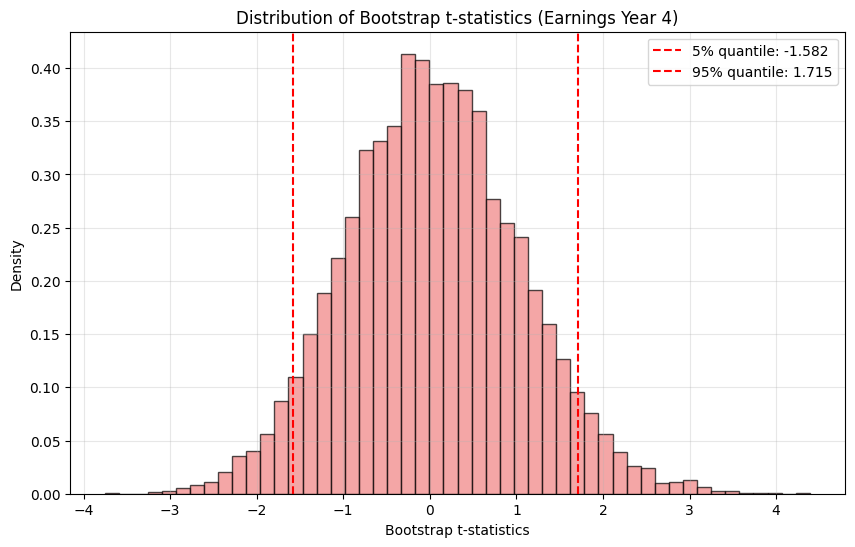

In [27]:
plt.figure(figsize=(10, 6))
plt.hist(bootstrap_tstats, bins=50, density=True, alpha=0.7, color='lightcoral', edgecolor='black')
plt.axvline(quantile_05, color='red', linestyle='--', label=f'5% quantile: {quantile_05:.3f}')
plt.axvline(quantile_95, color='red', linestyle='--', label=f'95% quantile: {quantile_95:.3f}')
plt.xlabel('Bootstrap t-statistics')
plt.ylabel('Density')
plt.title('Distribution of Bootstrap t-statistics (Earnings Year 4)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

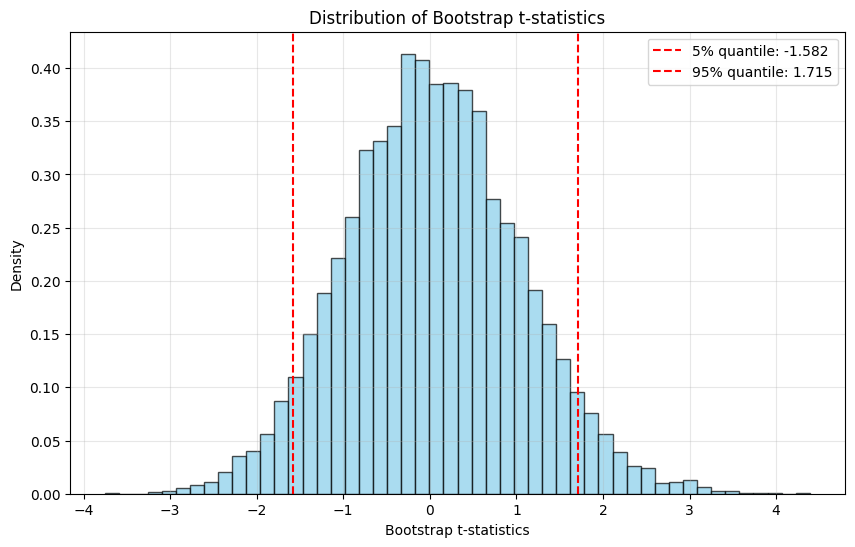

In [28]:
plt.figure(figsize=(10, 6))
plt.hist(bootstrap_tstats, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(quantile_05, color='red', linestyle='--', label=f'5% quantile: {quantile_05:.3f}')
plt.axvline(quantile_95, color='red', linestyle='--', label=f'95% quantile: {quantile_95:.3f}')
plt.xlabel('Bootstrap t-statistics')
plt.ylabel('Density')
plt.title('Distribution of Bootstrap t-statistics')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 4. Subsampling without Replacement (Earnings Year 1)

In [29]:
#Subsampling without replacement

B = 10000  # Number of bootstrap samples
n = df_clean.height  # Number of observations in the dataset
m = int(np.sqrt(n))  # Subsample size sqrt of the dataset size

bootstrap_means = []

DiM = (df_clean.filter(pl.col("treatment") == 1).select(pl.col("earnings1")).mean() - df_clean.filter(pl.col("treatment") == 0).select(pl.col("earnings1")).mean()).item()

for i in range(B):
    sample_indices = np.random.choice(n, m, replace=False)  # Sample without replacement
    sample = df_clean[sample_indices]  # Create the subsample
    sample_DiM = (sample.filter(pl.col("treatment") == 1).select(pl.col("earnings1")).mean() - sample.filter(pl.col("treatment") == 0).select(pl.col("earnings1")).mean()).item()

    bootstrap_means.append(sample_DiM)  # Calculate the mean of 'earnings1' in the subsample

bootstrap_variance = (m/n) * (1/B) * sum((x - DiM)**2 for x in bootstrap_means)
z_score_90 = norm.ppf(0.95)

print('Difference in means (DiM) for earnings1:', DiM)
print('Bootstrap variance of the mean of earnings1:', bootstrap_variance)

print('90 percent confidence interval for the mean of earnings1:', DiM - z_score_90 * np.sqrt(bootstrap_variance), DiM + z_score_90 * np.sqrt(bootstrap_variance))

Difference in means (DiM) for earnings1: 1.13621021012212
Bootstrap variance of the mean of earnings1: 0.018700756444036213
90 percent confidence interval for the mean of earnings1: 0.9112753102426332 1.361145110001607


## 4. Subsampling without Replacement (Earnings Year 4)

In [30]:
B = 10000  # Number of bootstrap samples
n = df_clean.height  # Number of observations in the dataset
m = int(np.sqrt(n))  # Subsample size sqrt of the dataset size

bootstrap_means = []

DiM = (df_clean.filter(pl.col("treatment") == 1).select(pl.col("earnings4")).mean() - df_clean.filter(pl.col("treatment") == 0).select(pl.col("earnings4")).mean()).item()

for i in range(B):
    sample_indices = np.random.choice(n, m, replace=False)  # Sample without replacement
    sample = df_clean[sample_indices]  # Create the subsample
    sample_DiM = (sample.filter(pl.col("treatment") == 1).select(pl.col("earnings4")).mean() - sample.filter(pl.col("treatment") == 0).select(pl.col("earnings4")).mean()).item()

    bootstrap_means.append(sample_DiM)  # Calculate the mean of 'earnings4' in the subsample

bootstrap_variance = (m/n) * (1/B) * sum((x - DiM)**2 for x in bootstrap_means)
z_score_90 = norm.ppf(0.95)

print('Difference in means (DiM) for earnings4:', DiM)

print('Bootstrap variance of the mean of earnings4:', bootstrap_variance)
print('90 percent confidence interval for the mean of earnings4:', DiM - z_score_90 * np.sqrt(bootstrap_variance), DiM + z_score_90 * np.sqrt(bootstrap_variance))

Difference in means (DiM) for earnings4: 1.2323321274413166
Bootstrap variance of the mean of earnings4: 0.06566348668541888
90 percent confidence interval for the mean of earnings4: 0.81084023359896 1.6538240212836732


## 5. Stratified Bayesian Bootstrap (Earnings Year 1)

In [31]:
## Stratified Bayesian Booystrap

B = 10000 # Number of bootstrap samples
n = df_clean.height  # Number of observations in the dataset

highschool_sample = df_clean.filter(pl.col("highschool") == 1)
highschool_n = highschool_sample.height

nohighschool_sample = df_clean.filter(pl.col("highschool") == 0)
nohighschool_n = nohighschool_sample.height



hs_bootstrap_means = []
nohs_bootstrap_means = []

highschool_DiM = (highschool_sample.filter(pl.col("treatment") == 1).select(pl.col("earnings1")).mean() - highschool_sample.filter(pl.col("treatment") == 0).select(pl.col("earnings1")).mean()).item()
nohighschool_DiM = (nohighschool_sample.filter(pl.col("treatment") == 1).select(pl.col("earnings1")).mean() - nohighschool_sample.filter(pl.col("treatment") == 0).select(pl.col("earnings1")).mean()).item()

for i in range(B):
    hs_weights = np.random.exponential(1, highschool_n)  # Generate exponential weights
    hs_weights /= hs_weights.sum()  # Normalize to sum to 1

    sample = highschool_sample.with_columns(
        pl.Series(hs_weights).alias("weights"),
        (pl.Series(hs_weights) * pl.col("earnings1")).alias("weighted_earnings1")
    )  # Use the original dataset

    sample_hs_DiM = (sample.filter(pl.col("treatment") == 1).select(pl.col("weighted_earnings1")).sum() / sample.filter(pl.col("treatment") == 1).select(pl.col("weights")).sum() - 
                 sample.filter(pl.col("treatment") == 0).select(pl.col("weighted_earnings1")).sum() / sample.filter(pl.col("treatment") == 0).select(pl.col("weights")).sum()).item()

    hs_bootstrap_means.append(sample_hs_DiM)  # Store the weighted mean difference

    nohs_weights = np.random.exponential(1, nohighschool_n)  # Generate exponential weights
    nohs_weights /= nohs_weights.sum()  # Normalize to sum to 1

    sample = nohighschool_sample.with_columns(
        pl.Series(nohs_weights).alias("weights"),   
        (pl.Series(nohs_weights) * pl.col("earnings1")).alias("weighted_earnings1")
    )  # Use the original dataset

    sample_nohs_DiM = (sample.filter(pl.col("treatment") == 1).select(pl.col("weighted_earnings1")).sum() / sample.filter(pl.col("treatment") == 1).select(pl.col("weights")).sum() - 
                 sample.filter(pl.col("treatment") == 0).select(pl.col("weighted_earnings1")).sum() / sample.filter(pl.col("treatment") == 0).select(pl.col("weights")).sum()).item()

    nohs_bootstrap_means.append(sample_nohs_DiM)  # Store the weighted mean difference


bootstrap_variance_hs = (1/B) * sum((x - highschool_DiM)**2 for x in hs_bootstrap_means)
bootstrap_variance_nohs = (1/B) * sum((x - nohighschool_DiM)**2 for x in nohs_bootstrap_means)

z_score_95 = norm.ppf(0.975)

print('Difference in means (DiM) for earnings1 (highschool):', highschool_DiM)
print('Difference in means (DiM) for earnings1 (no highschool):', nohighschool_DiM)
print('Bootstrap variance of the mean of earnings1 (highschool):', bootstrap_variance_hs)
print('Bootstrap variance of the mean of earnings1 (no highschool):', bootstrap_variance_nohs)

print('95 percent confidence interval for the mean of earnings1 (highschool):', highschool_DiM - z_score_95 * np.sqrt(bootstrap_variance_hs), highschool_DiM + z_score_95 * np.sqrt(bootstrap_variance_hs))
print('95 percent confidence interval for the mean of earnings1 (no highschool):', nohighschool_DiM - z_score_95 * np.sqrt(bootstrap_variance_nohs), nohighschool_DiM + z_score_95 * np.sqrt(bootstrap_variance_nohs))

combined_DiM = (highschool_n / n) * highschool_DiM + (nohighschool_n / n) * nohighschool_DiM
combined_variance = (highschool_n / n)**2 * bootstrap_variance_hs + (nohighschool_n / n)**2 * bootstrap_variance_nohs

print('Combined DiM:', combined_DiM)
print('Combined variance:', combined_variance)
print('95 percent confidence interval for the combined DiM:', combined_DiM - z_score_95 * np.sqrt(combined_variance), combined_DiM + z_score_95 * np.sqrt(combined_variance))

Difference in means (DiM) for earnings1 (highschool): 1.4999478892119926
Difference in means (DiM) for earnings1 (no highschool): 0.7371518881118884
Bootstrap variance of the mean of earnings1 (highschool): 0.041709719280322084
Bootstrap variance of the mean of earnings1 (no highschool): 0.027352895336271384
95 percent confidence interval for the mean of earnings1 (highschool): 1.0996652777509537 1.9002305006730316
95 percent confidence interval for the mean of earnings1 (no highschool): 0.41299911385098076 1.061304662372796
Combined DiM: 1.1362156753639265
Combined variance: 0.01763518880041861
95 percent confidence interval for the combined DiM: 0.8759372637121449 1.396494087015708


## 5. Stratified Bayesian Bootstrap (Earnings Year 4)

In [32]:
B = 10000 # Number of bootstrap samples
n = df_clean.height  # Number of observations in the dataset

highschool_sample = df_clean.filter(pl.col("highschool") == 1)
highschool_n = highschool_sample.height

nohighschool_sample = df_clean.filter(pl.col("highschool") == 0)
nohighschool_n = nohighschool_sample.height

hs_bootstrap_means = []
nohs_bootstrap_means = []

highschool_DiM = (highschool_sample.filter(pl.col("treatment") == 1).select(pl.col("earnings4")).mean() - highschool_sample.filter(pl.col("treatment") == 0).select(pl.col("earnings4")).mean()).item()
nohighschool_DiM = (nohighschool_sample.filter(pl.col("treatment") == 1).select(pl.col("earnings4")).mean() - nohighschool_sample.filter(pl.col("treatment") == 0).select(pl.col("earnings4")).mean()).item()

for i in range(B):
    hs_weights = np.random.exponential(1, highschool_n)  # Generate exponential weights
    hs_weights /= hs_weights.sum()  # Normalize to sum to 1

    sample = highschool_sample.with_columns(
        pl.Series(hs_weights).alias("weights"),
        (pl.Series(hs_weights) * pl.col("earnings4")).alias("weighted_earnings4")
    )  # Use the original dataset

    sample_hs_DiM = (sample.filter(pl.col("treatment") == 1).select(pl.col("weighted_earnings4")).sum() / sample.filter(pl.col("treatment") == 1).select(pl.col("weights")).sum() - 
                 sample.filter(pl.col("treatment") == 0).select(pl.col("weighted_earnings4")).sum() / sample.filter(pl.col("treatment") == 0).select(pl.col("weights")).sum()).item()

    hs_bootstrap_means.append(sample_hs_DiM)  # Store the weighted mean difference

    nohs_weights = np.random.exponential(1, nohighschool_n)  # Generate exponential weights
    nohs_weights /= nohs_weights.sum()  # Normalize to sum to 1

    sample = nohighschool_sample.with_columns(
        pl.Series(nohs_weights).alias("weights"),   
        (pl.Series(nohs_weights) * pl.col("earnings4")).alias("weighted_earnings4")
    )  # Use the original dataset

    sample_nohs_DiM = (sample.filter(pl.col("treatment") == 1).select(pl.col("weighted_earnings4")).sum() / sample.filter(pl.col("treatment") == 1).select(pl.col("weights")).sum() - 
                 sample.filter(pl.col("treatment") == 0).select(pl.col("weighted_earnings4")).sum() / sample.filter(pl.col("treatment") == 0).select(pl.col("weights")).sum()).item()

    nohs_bootstrap_means.append(sample_nohs_DiM)  # Store the weighted mean difference

bootstrap_variance_hs = (1/B) * sum((x - highschool_DiM)**2 for x in hs_bootstrap_means)
bootstrap_variance_nohs = (1/B) * sum((x - nohighschool_DiM)**2 for x in nohs_bootstrap_means)

z_score_95 = norm.ppf(0.975)

print('Difference in means (DiM) for earnings4 (highschool):', highschool_DiM)
print('Difference in means (DiM) for earnings4 (no highschool):', nohighschool_DiM)
print('Bootstrap variance of the mean of earnings4 (highschool):', bootstrap_variance_hs)
print('Bootstrap variance of the mean of earnings4 (no highschool):', bootstrap_variance_nohs)

print('95 percent confidence interval for the mean of earnings4 (highschool):', highschool_DiM - z_score_95 * np.sqrt(bootstrap_variance_hs), highschool_DiM + z_score_95 * np.sqrt(bootstrap_variance_hs))
print('95 percent confidence interval for the mean of earnings4 (no highschool):', nohighschool_DiM - z_score_95 * np.sqrt(bootstrap_variance_nohs), nohighschool_DiM + z_score_95 * np.sqrt(bootstrap_variance_nohs))

combined_DiM = (highschool_n / n) * highschool_DiM + (nohighschool_n / n) * nohighschool_DiM
combined_variance = (highschool_n / n)**2 * bootstrap_variance_hs + (nohighschool_n / n)**2 * bootstrap_variance_nohs

print('Combined DiM (earnings4):', combined_DiM)
print('Combined variance (earnings4):', combined_variance)
print('95 percent confidence interval for the combined DiM (earnings4):', combined_DiM - z_score_95 * np.sqrt(combined_variance), combined_DiM + z_score_95 * np.sqrt(combined_variance))

Difference in means (DiM) for earnings4 (highschool): 1.4801919207020253
Difference in means (DiM) for earnings4 (no highschool): 0.9604370997423632
Bootstrap variance of the mean of earnings4 (highschool): 0.17131793053402639
Bootstrap variance of the mean of earnings4 (no highschool): 0.060299447764907387
95 percent confidence interval for the mean of earnings4 (highschool): 0.6689516508725505 2.2914321905315003
95 percent confidence interval for the mean of earnings4 (no highschool): 0.4791494045958032 1.4417247948889234
Combined DiM (earnings4): 1.2323516443854046
Combined variance (earnings4): 0.06059967809679173
95 percent confidence interval for the combined DiM (earnings4): 0.7498672736995292 1.7148360150712798
